In [8]:
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely import wkt
from typing import Union
from keplergl import KeplerGl
from shapely.ops import cascaded_union
from scipy.stats import zscore
import numpy as np

In [2]:
sample = pd.read_csv('sample.csv')

In [3]:
# Перед отправкой данных в алгорит , нужно избавиться от экстримальных выбросов

good_data_index = (
    (sample['latitude'] != 0) & 
    (sample['latitude'].notna()) &
    (sample['longitude'] != 0) & 
    (sample['longitude'].notna()) 
)

sample = sample[good_data_index].reset_index(drop=True)

good_data_index = (
    (abs(zscore(sample['latitude'])) <= 3.3) & 
    (abs(zscore(sample['longitude'])) <= 3.3)
)

one_big_df = sample[good_data_index].reset_index(drop=True)

In [9]:
# В датафрейме должен лежать столбец latitude и столбец longitude

def get_kernel_polygon(data_lat_lon, proba_line=0.8): # proba_line - Какую плотностную долю координат обводить алгоритмом
    

    cs = sns.kdeplot(
        data=data_lat_lon, x="latitude", y="longitude",
        levels=[1 - proba_line],
        shade=False
    )

    index = 0
    tots_polys = {}
    for collection in cs.collections:
        for path in collection.get_paths():
            polygone = np.array(path.to_polygons()[0])
            polygone = Polygon(np.array(list(zip(polygone[:, 1], polygone[:, 0]))))

            tots_polys[str(index)] = polygone
            index += 1


    one_big_poly = cascaded_union(list(tots_polys.values()))

    return one_big_poly

In [10]:
(f"Объем данных: {sample.shape[0]}")

'Объем данных: 277508'

CPU times: user 3min 7s, sys: 4.56 s, total: 3min 11s
Wall time: 3min 6s


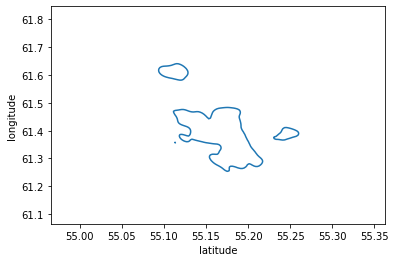

In [11]:
%%time
poly = get_kernel_polygon(sample)

In [12]:
# Полигон для отрисовки в kepler
data_map = pd.DataFrame(pd.Series(poly)).reset_index(drop=False).rename({0: 'poly'}, axis=1).astype(str)

In [13]:
map_2 = KeplerGl(height=800,)
map_2.add_data(data_map, 'poly')
map_2.add_data(sample[['latitude', 'longitude']], 'data')


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [14]:
map_2

KeplerGl(data={'poly': {'index': [0, 1, 2, 3], 'columns': ['index', 'poly'], 'data': [['0', 'POLYGON ((61.5822…